# Loading and visualizing results ([open in colab](https://colab.research.google.com/github/openai/baselines/blob/master/docs/viz/viz.ipynb))
In order to compare performance of algorithms, we often would like to visualize learning curves (reward as a function of time steps), or some other auxiliary information about learning aggregated into a plot. Baselines repo provides tools for doing so in several different ways, depending on the goal.

## Preliminaries / TensorBoard
First, let us install baselines repo from github

In [0]:
!pip install git+https://github.com/openai/baselines > ~/pip_install_baselines.log

For all algorithms in baselines summary data is saved into a folder defined by logger. By default, a folder $TMPDIR/openai-<date>-<time> is used; you can see the location of logger directory at the beginning of the training in the message like this:

Logging to /var/folders/mq/tgrn7bs17s1fnhlwt314b2fm0000gn/T/openai-2018-10-29-15-03-13-537078
The location can be changed by changing OPENAI_LOGDIR environment variable. For instance, 

In [1]:
!OPENAI_LOGDIR=/home_local/pitz_ja/logs/cartpole-ppo OPENAI_LOG_FORMAT=csv,tensorboard python -m baselines.run --alg=ppo2 --env=CartPole-v0 --num_timesteps=30000 --nsteps=128

/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/volume/USERSTOR

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 8565 tid 8588 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 8565 tid 8595 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 8565 tid 8597 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 8565 tid 8596 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 8565 tid 8598 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 8565 tid 8599 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AFFINITY: pid 8565 tid 8600 thread 12 bound to OS proc set 0


Notice also the usage of `OPENAI_LOG_FORMAT` environment variable - this allows us to suppress printing to stdout. 
Permissible values for `OPENAI_LOG_FORMAT` environment variables are `stdout`, `log`, `csv`, and `tensorboard` (multiple values can be comma-separated). 
The latter one (`tensorboard`) dumps values in tensorboard format, which allows for their viewing in [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard). TensorBoard provides nice visualization and in many cases is the easiest way to look at the summary of the results. However, if tensorboard visualization is not sufficient, read on...


## Loading results and plotting using matplotlib
Bаselines provides helper functions to load the summaries of the results as pandas dataframes. 
For instance, the following:

In [2]:
from baselines.common import plot_util as pu
results = pu.load_results('/home_local/pitz_ja/logs/cartpole-ppo') 

/volume/USERSTORE/pitz_ja/openai/baselines/baselines/bench/monitor.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


will search for all folders with baselines-compatible results in ~/logs/cartpole-ppo and subfolders and return a list of `Result` objects. Each `Result` object is a named tuple with the following fields:

  * dirname: str - name of the folder from which data was loaded
  
  * metadata: dict) - dictionary with various metadata (read from metadata.json file)

  * progress: pandas.DataFrame - tabular data saved by logger as a pandas dataframe. Available if csv is in logger formats.

  * monitor: pandas.DataFrame - raw episode data (length, episode reward, timestamp). Available if environment wrapped with Monitor wrapper
  
Thus, a learning curve from a single run can be plotted as follows (note the cumulative sum trick to get convert lengths of the episodes into number of time steps taken so far)
 

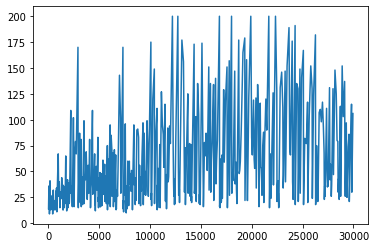

In [3]:
import matplotlib.pyplot as plt
import numpy as np
r = results[0]
plt.plot(np.cumsum(r.monitor.l), r.monitor.r)

The raw learning curve from a single run can be very noisy. To smoothen it and analyze if any learning actually takes place, we can use `plot_util.smooth()` function:

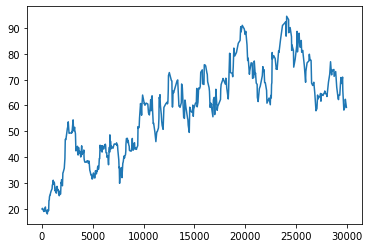

In [4]:
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=10))

Similar curve can be obtained by using logger summaries (instead of raw episode data in monitor.csv):


In [11]:
r.progress['misc/total_timesteps']


# r.progress.eprewmean

0       128
1      1280
2      2560
3      3840
4      5120
5      6400
6      7680
7      8960
8     10240
9     11520
10    12800
11    14080
12    15360
13    16640
14    17920
15    19200
16    20480
17    21760
18    23040
19    24320
20    25600
21    26880
22    28160
23    29440
Name: misc/total_timesteps, dtype: int64

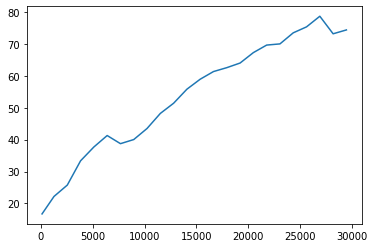

In [12]:

plt.plot(r.progress['misc/total_timesteps'], r.progress.eprewmean)

Note, however, that raw episode data is stored by the Monitor wrapper, and hence looks similar for all algorithms, whereas progress data is handled by the algorithm itself, and hence can vary (column names, type of data available) between algorithms.

## Plotting: many curves
While the loading and plotting functions described above in principle give you access to any slice of the training summaries, sometimes it is necessary to plot and compare many training runs (multiple algorithms, multiple seeds for random number generator), and usage of the functions above can get tedious and messy. For that case, `baselines.common.plot_util` provides convenience function plot_results that handles multiple `Result` objects that need to be routed in multiple plots. Consider the following bash snippet that runs ppo2 with cartpole with 6 different seeds for 30k time steps, first with rollout batch size 32, and then with batch size 128 (note that the next cell will take a little while to run):

In [13]:
!for seed in $(seq 0 5); do OPENAI_LOG_FORMAT=csv,tensorboard OPENAI_LOGDIR=/home_local/pitz_ja/logs/cartpole-ppo-hp/b32-$seed python -m baselines.run --alg=ppo2 --env=CartPole-v0 --num_timesteps=3e4 --seed=$seed --nsteps=32; done
!for seed in $(seq 0 5); do OPENAI_LOG_FORMAT=csv,tensorboard OPENAI_LOGDIR=/home_local/pitz_ja/logs/cartpole-ppo-hp/b128-$seed python -m baselines.run --alg=ppo2 --env=CartPole-v0 --num_timesteps=3e4 --seed=$seed --nsteps=128; done

/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/volume/USERSTOR

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 8933 tid 8956 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 8933 tid 8962 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 8933 tid 8963 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 8933 tid 8964 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 8933 tid 8965 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 8933 tid 8966 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AFFINITY: pid 8933 tid 8967 thread 12 bound to OS proc set 0
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTO

OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9029 thread 2 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9030 thread 3 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9032 thread 5 bound to OS proc set 5
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9031 thread 4 bound to OS proc set 4
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9027 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9039 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9040 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9041 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9043 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9042 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 8997 tid 9044 thread 12 bound to OS proc set 0
/volume/USERSTORE/pit

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9096 tid 9121 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9096 tid 9127 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9096 tid 9128 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9096 tid 9129 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 9096 tid 9130 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9096 tid 9131 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AFFINITY: pid 9096 tid 9132 thread 12 bound to OS proc set 0
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTO

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9145 tid 9169 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9145 tid 9175 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9145 tid 9176 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9145 tid 9177 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 9145 tid 9178 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9145 tid 9180 thread 12 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 9145 tid 9179 thread 11 bound to OS proc set 11
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTO

OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9218 thread 2 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9217 thread 1 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9219 thread 3 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9220 thread 4 bound to OS proc set 4
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9221 thread 5 bound to OS proc set 5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9216 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9222 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9223 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9224 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9225 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9193 tid 9226 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AF

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9251 tid 9277 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9251 tid 9283 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9251 tid 9284 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9251 tid 9285 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 9251 tid 9286 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9251 tid 9288 thread 12 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 9251 tid 9287 thread 11 bound to OS proc set 11
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTO

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9332 tid 9355 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9332 tid 9362 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9332 tid 9363 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 9332 tid 9364 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9332 tid 9361 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9332 tid 9365 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AFFINITY: pid 9332 tid 9366 thread 12 bound to OS proc set 0
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTO

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9374 tid 9396 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9374 tid 9402 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9374 tid 9406 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AFFINITY: pid 9374 tid 9403 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9374 tid 9407 thread 12 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 9374 tid 9405 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9374 tid 9404 thread 9 bound to OS proc set 9
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTO

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9418 tid 9461 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9418 tid 9478 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9418 tid 9480 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9418 tid 9481 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 9418 tid 9482 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9418 tid 9483 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AFFINITY: pid 9418 tid 9484 thread 12 bound to OS proc set 0
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTO

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9542 tid 9586 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9542 tid 9595 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9542 tid 9594 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9542 tid 9600 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 9542 tid 9601 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9542 tid 9602 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AFFINITY: pid 9542 tid 9604 thread 12 bound to OS proc set 0
/volume/USERSTORE/pitz_ja/anaconda3/envs/cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/volume/USERSTO

OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9677 thread 1 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9678 thread 2 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9679 thread 3 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9680 thread 4 bound to OS proc set 4
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9681 thread 5 bound to OS proc set 5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9676 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9682 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9683 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9684 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9685 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9619 tid 9686 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AF

OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9720 thread 1 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9722 thread 3 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9721 thread 2 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9723 thread 4 bound to OS proc set 4
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9724 thread 5 bound to OS proc set 5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9719 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9725 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9744 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9745 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9746 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 9692 tid 9747 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AF

The results of 12 runs from the cell above can be loaded just as before, via (we discard first result that is actually from the very first run in the previous section):

In [14]:
results = pu.load_results('/home_local/pitz_ja/logs/cartpole-ppo-hp'); print(len(results))

12


/volume/USERSTORE/pitz_ja/openai/baselines/baselines/bench/monitor.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


But how do we plot all 12 of them in a sensible manner? `baselines.common.plot_util` module provides plot_results function to do just that:

(<Figure size 432x864 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8584a368d0>],
       dtype=object))

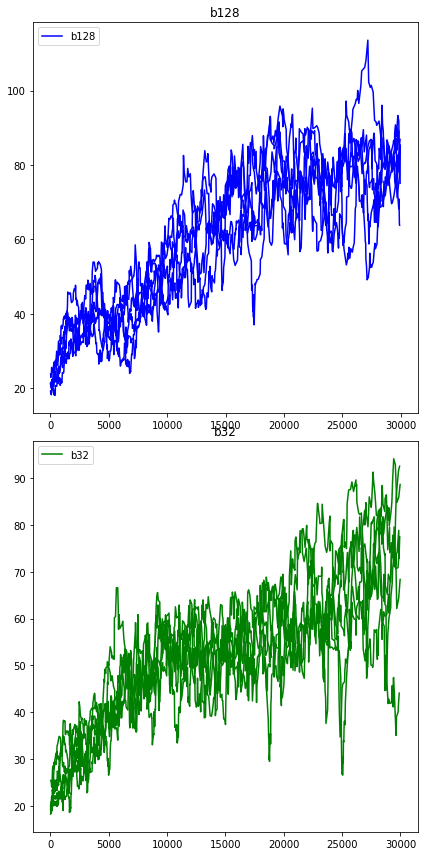

In [15]:
pu.plot_results(results)

The results are split into two groups based on batch size and are plotted on a separate graph. More specifically, by default plot_results considers digits after dash at the end of the directory name to be seed id and groups the runs that differ only by those together.

Showing all seeds on the same plot may be somewhat hard to comprehend and analyse. We can instead average over all seeds via the following command:

(<Figure size 432x864 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8584c22290>],
       dtype=object))

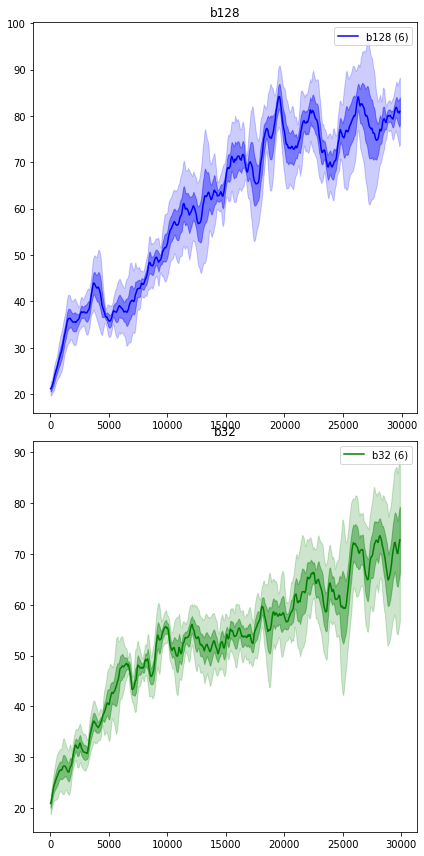

In [16]:
pu.plot_results(results, average_group=True)

The lighter shade shows the standard deviation of data, and darker shade - error in estimate of the mean (that is, standard deviation divided by square root of number of seeds). Note that averaging over seeds requires resampling to a common grid, which, in turn, requires smoothing (using language of signal processing, we need to do low-pass filtering before resampling to avoid aliasing effects). You can change the amount of smoothing by adjusting `resample` and `smooth_step` arguments to achieve desired smoothing effect See the docstring of plot_util function for more info.

To plot both groups on the same graph, we can use the following:

(<Figure size 432x432 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f858475af90>]],
       dtype=object))

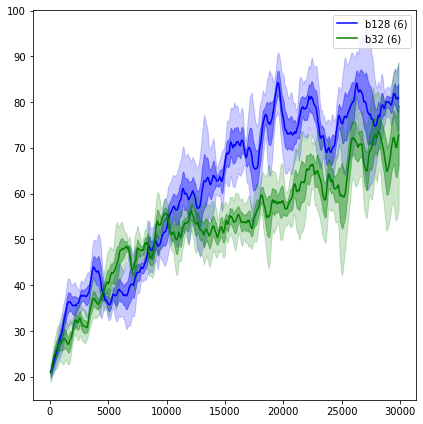

In [17]:
pu.plot_results(results, average_group=True, split_fn=lambda _: '')

Option `split_fn=labmda _:''` effectively disables splitting, so that all curves end up on the same panel.

Now, with many groups the overlapping shaded regions may start looking messy. We can disable either light shaded region (corresponding to standard deviation of the curves in the group) or darker shaded region (corresponding to the error in mean estimate) by using `shaded_std=False` or `shaded_err=False` options respectively. For instance,

(<Figure size 432x432 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85846aa650>]],
       dtype=object))

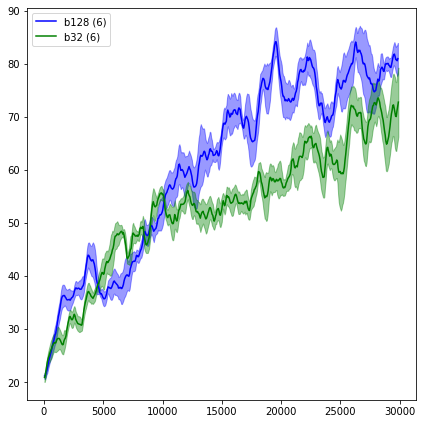

In [18]:
pu.plot_results(results, average_group=True, split_fn=lambda _: '', shaded_std=False)